# L3.2 - Basic linear registration

In this lab, you will perform some basic linear registration in a more automated way.

First of all, you should import the following useful modules:

In [1]:
import numpy as np
from scipy import ndimage as ndi
from scipy import optimize
from scipy.stats import entropy
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from scipy.interpolate import griddata

## Task 1: Human brain
You can now read the image 't1_flair_pad.png', which you have already worked with in the previous lab.

In [2]:
img = pltimg.imread('t1_flair_pad.png')

Below you should include your implementations of the functions _ssd_ (sum of squared differences) and _mi_ (normalized mutual information) that you have defined in the previous lab. You are going to use them for this lab as well.

In [45]:
def ssd(img1, img2):
    # TODO: compute the sum of squared differences (the sum is here used instead of the integral seen in the lecture slides)
    dist = np.sum((img1-img2) ** 2)            
    # normalization
    dist /= float(img1.shape[0] * img1.shape[1]) 
    return dist

def mi(img1, img2, nbins=100):
    # the Parzen window method is used
    hist, bin_edges = np.histogramdd([np.ravel(img1), np.ravel(img2)], bins=nbins)
    # TODO: normalize the histogram
    hist /= np.sum(hist)
    # TODO: compute the entropy of img1 and img2
    H1 = entropy(np.sum(hist,axis=0))
    H2 = entropy(np.sum(hist,axis=1))
    # compute the joint entropy
    H12 = entropy(np.ravel(hist))
    # TODO: define the distance function as the inverse of the sum of the entropy of img1 and img2
    # divided by the joint entropy
    dist =  H12/(H1+H2)
    return dist

You can now read the image 't1_flair_transformed.png' and plot it below. As you will see, it is the same image as the reference image 't1_flair_pad.png', but not perfectly aligned to it (as it usually happens with medical images).

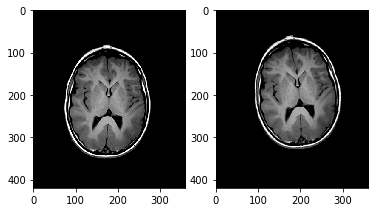

In [31]:
# TODO: read the image
transf_img = pltimg.imread('t1_flair_transformed.png')

# TODO: plot the image
plt.figure()
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.subplot(122)
plt.imshow(transf_img,cmap='gray')
plt.show()

You can define a new function 'error_affinetransf'. This function takes the following inputs:
- par: a vector containing the parameters _sx_, _sy_, _rot_, _shear_, _tx_, _ty_ (which you are already familiar with) to perform the affine transformation;
- ref_img: the reference image;
- mov_img: the moving image;
- errtype: a string indicating the type of error (cost function) that we want to get as a measure of dissimilarity between ref_img and mov_img. It can be either 'SSD' (sum of squared differences) or 'MI' (mutual information). You can set 'SSD' as default error type.

The function will: <br>
1) Define the affine transformation according to the values in 'par'. <br>
2) Apply the transformation to mov_img to get the transformed image transf_img.<br>
3) Return the error according to the chosen errtype.

Notice that, to speed up the computations, we are performing the transformation and subsequent interpolation using a function from scipy (so a bit less "low level" compared to the implementation that you performed in the previous lab!).<br>
According to this implementation, you should __first define a transformation matrix that includes only scaling, rotation and shearing__ (so no translation!). The __translation is then defined separately by using the offset parameter__ of the function affine_transform.

In [32]:
def error_affinetransf(par, ref_img, mov_img, errtype='SSD'):
    
    # TODO: define the transformation matrix (1. scaling, 2. rotation, 3. shearing)
    transf_matrix = np.array([par[0]*np.cos(par[2])+par[4]*par[0]*np.sin(par[2]),-par[1]*np.sin(par[2])+par[4]*par[1]*np.cos(par[2]), par[0]*par[3]*np.cos(par[2])+par[0]*np.sin(par[2]), -par[3]*par[1]*np.sin(par[2])+par[1]*np.cos(par[2])])
    transf_matrix=np.reshape(transf_matrix,[2,2])
    # TODO: apply the affine transformation (including the translation as 'offset')
    transf_img = ndi.interpolation.affine_transform(mov_img, transf_matrix, offset=[par[5],par[6]])
    
    # TODO: compute output
    if errtype == 'SSD':
        error = ssd(ref_img,transf_img)
    elif errtype == 'MI':
        error = mi(ref_img,transf_img)
    else:
        raise Exception('Please type SSD for Sum of Squared Differences or MI for Mutual Information')
            
    return error

Now, it is time to try to automatically register the image above. Let's start by testing the sum of squared differences (SSD) as cost function.<br>
You will have to use the function _optimize.minimize_ to find the optimal set of parameters which minimizes the chosen cost function. Please search and have a look at the documentation of _optimize.minimize_.<br>

In the documentation, you can see that the first input parameter is the objective function to be minimized, which you have defined in the cell above.<br>
Moreover, you will also have to provide an array that represents the initial guess of the optimal values of par. For this exercise, as initial guess you can assume that the two images are identical: __how does the vector of parameters [_sx_, _sy_, _rot_, _shear_, _tx_, _ty_] look like in this situation?__<br>
As a third input parameter, you will have to provide the remaining input parameters of error_affinetransf.<br>
Finally, as you have seen in the lecture, there are several types of optimization methods. In the documentation, you can see that different types of solvers can be chosen. One of those is the Powell's method, which you have also seen at the lecture and you could try to use for this lab.

In [33]:
# TODO: initial guess for the parameters: the images are identical
initial_guess = np.array([1,1,0,0,0,0,0], np.float32)

# TODO: define the cost function
errtype = 'SSD'

# TODO: optimization
ssd_result = optimize.minimize(error_affinetransf,initial_guess, options={'disp': True}, method='Powell',args=(img, transf_img, errtype))

# TODO: get the optimal set of parameters and the cost function
ssd_par = ssd_result.x
ssd_fun = ssd_result.fun
print('The optimal set of parameters is: {} and the optimal cost function value is: {}'.format(ssd_par,ssd_fun))

Optimization terminated successfully.
         Current function value: 0.000153
         Iterations: 19
         Function evaluations: 1919
The optimal set of parameters is: [ 0.99982763  0.99984186  0.10758282  0.01807453 -0.01807059  1.25351836
 -9.92034582] and the optimal cost function value is: 0.00015345956913377873


When the optimization finishes running, you can check your result and see if your registration algorithm actually worked. :) __What is the value of the cost function? Which is the optimal set of parameters? Which type of transformation do the parameters describe?__<br>
Then, you can use the optimal parameters to define a new affine transformation and apply it to transf_img, in order to get the registered image ssd_reg_img.<br>
Finally, you can plot your images (including also the difference, as you did in the previous lab) to check visually if everything worked!

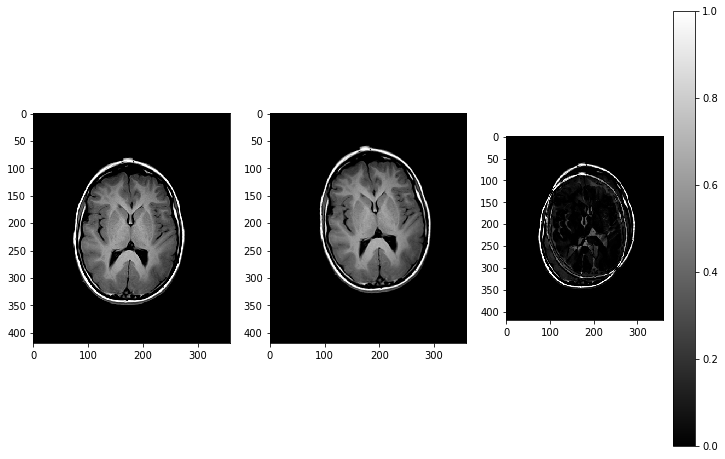

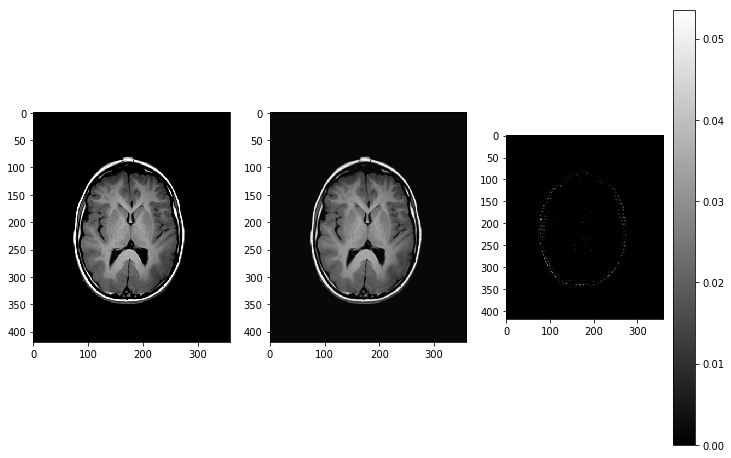

In [39]:
# TODO: apply the new affine transformation (according to ssd_par) to transf_img
transf_matrix = np.array([ssd_par[0]*np.cos(ssd_par[2])+ssd_par[4]*ssd_par[0]*np.sin(ssd_par[2]),-ssd_par[1]*np.sin(ssd_par[2])+ssd_par[4]*ssd_par[1]*np.cos(ssd_par[2]), ssd_par[0]*ssd_par[3]*np.cos(ssd_par[2])+ssd_par[0]*np.sin(ssd_par[2]), -ssd_par[3]*ssd_par[1]*np.sin(ssd_par[2])+ssd_par[1]*np.cos(ssd_par[2])])
transf_matrix=np.reshape(transf_matrix,[2,2])
ssd_reg_img = ndi.interpolation.affine_transform(transf_img,transf_matrix,offset=[ssd_par[5],ssd_par[6]])

# TODO: plot the images
# before the registration
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img,cmap='gray')
plt.subplot(132)
plt.imshow(transf_img,cmap='gray')
plt.subplot(133)
plt.imshow((transf_img-img)**2,cmap='gray')
plt.colorbar()
plt.show()
# after the registration
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img,cmap='gray')
plt.subplot(132)
plt.imshow(ssd_reg_img,cmap='gray')
plt.subplot(133)
plt.imshow((ssd_reg_img-img)**2,cmap='gray')
plt.colorbar()
plt.show()

If everything worked so far, you can try to test whether the optimization works also with the other implemented cost functions: 'MI' (normalized mutual information).

In [46]:
# TODO: optimization with MI
errtype = 'MI'
initial_guess = np.array([1,1,0,0,0,0,0], np.float32)
mi_result = optimize.minimize(error_affinetransf,initial_guess, options={'disp': True},args=(img, transf_img, errtype))
# TODO: get the optimal set of parameters and the cost function
mi_par = mi_result.x
mi_fun = mi_result.fun
print('The optimal set of parameters is: {} and the optimal cost function value is: {}'.format(mi_par,mi_fun))

Optimization terminated successfully.
         Current function value: 0.873051
         Iterations: 3
         Function evaluations: 99
         Gradient evaluations: 11
The optimal set of parameters is: [ 1.04040825  1.04389638  0.08942437  0.01562736 -0.04427461  0.
  0.        ] and the optimal cost function value is: 0.8730511225537684


Now, you can plot the new result. __Is the result different compared to SSD? If so, is there anything that you can change to improve the performance of the optimizer (still using the normalized mutual information as cost function)?__ Test your ideas by changing and re-running the cell above, and checking your results using the cell below.

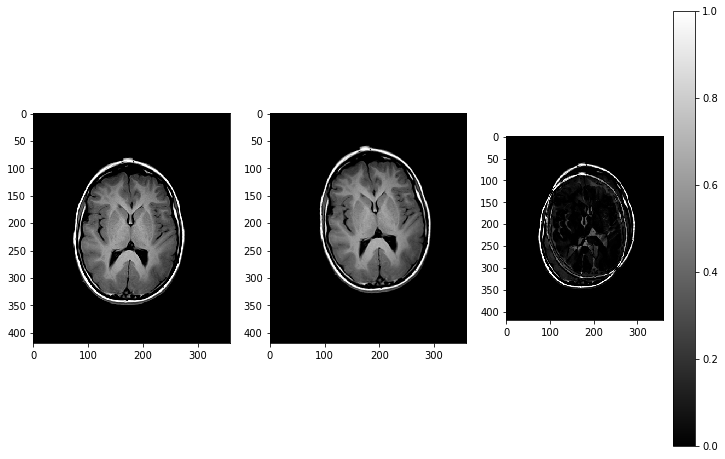

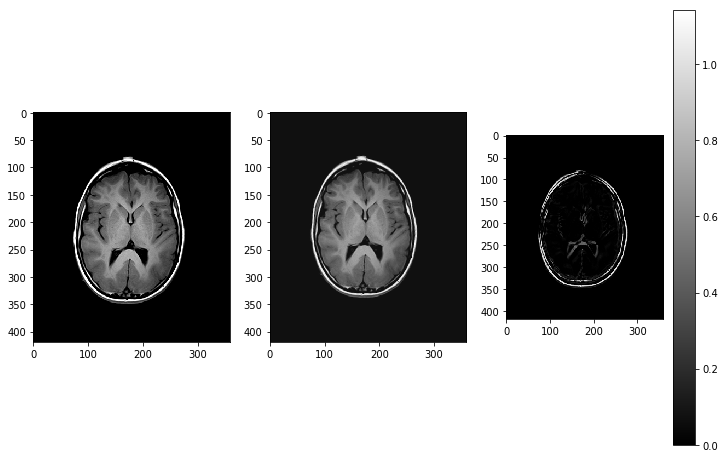

In [47]:
# TODO: apply the new affine transformation (according to mi_par) to transf_img
transf_matrix = np.array([mi_par[0]*np.cos(mi_par[2])+mi_par[4]*mi_par[0]*np.sin(mi_par[2]),-mi_par[1]*np.sin(mi_par[2])+mi_par[4]*mi_par[1]*np.cos(mi_par[2]), mi_par[0]*mi_par[3]*np.cos(mi_par[2])+mi_par[0]*np.sin(mi_par[2]), -mi_par[3]*mi_par[1]*np.sin(mi_par[2])+mi_par[1]*np.cos(mi_par[2])])
transf_matrix=np.reshape(transf_matrix,[2,2])
mi_reg_img = ndi.interpolation.affine_transform(transf_img,transf_matrix,offset=[ssd_par[5],ssd_par[6]])

# TODO: plot the images
# before the registration
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img,cmap='gray')
plt.subplot(132)
plt.imshow(transf_img,cmap='gray')
plt.subplot(133)
plt.imshow((transf_img-img)**2,cmap='gray')
plt.colorbar()
plt.show()
# after the registration
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img,cmap='gray')
plt.subplot(132)
plt.imshow(mi_reg_img,cmap='gray')
plt.subplot(133)
plt.imshow((mi_reg_img-img)**2,cmap='gray')
plt.colorbar()
plt.show()

## Task 2: Rabbit brain
Once you have made sure that the optimization worked with both SSD and MI, you will now work on a very similar task, but with a new dataset. You will move from 2D human brain slices to 2D rabbit brain slices! <br>
You should import the following image files:
- 'rabbit_t1_2d.png': a slice of a T1-weighted image of a rabbit brain.
- 'rabbit_fa_2d.png': the same slice as above (from the same rabbit), but now showing its fractional anisotropy (FA) map. FA maps can be obtained from diffusion MRI image scans and they represent the amount of anisotropic water diffusion in each voxel. The higher the FA value, the higher the anisotropic diffusion, and therefore the more likely it is to have a single white matter bundle passing through that voxel.

Plot the two images below. You will notice that the FA map is not aligned to the T1 image and your task consists in registering the FA map (moving image) to the T1 image (reference image).

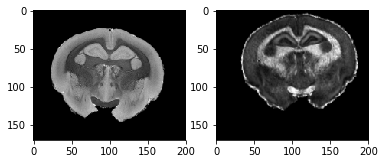

In [19]:
# TODO: read the images
t1 = pltimg.imread('rabbit_t1_2d.png')
fa = pltimg.imread('rabbit_fa_2d.png')

# TODO: plot the images
plt.figure()
plt.subplot(121)
plt.imshow(t1,cmap='gray')
plt.subplot(122)
plt.imshow(fa,cmap='gray')
plt.show()

You can now try to register them exactly as you did with the human brain above.<br>
First, perform the registration by using the sum of squared differences as cost function.

In [20]:
# TODO: initial guess for the parameters: the images are identical
initial_guess = np.array([1,1,0,0,0,0,0], np.float32)

# TODO: define the cost function
errtype = 'SSD'

# TODO: optimization!
ssd_result = optimize.minimize(error_affinetransf,initial_guess, options={'disp': True},args=(t1, fa, errtype))

Optimization terminated successfully.
         Current function value: 0.052570
         Iterations: 2
         Function evaluations: 72
         Gradient evaluations: 8


When the optimization finishes running, you can check your result. __What is the value of the cost function? Which is the optimal set of parameters? Which type of transformation do the parameters describe?__<br>
Then, you can use the optimal parameters to define a transformation matrix and apply an affine transformation to fa, in order to get the registered image ssd_reg_fa.<br>
Finally, you can plot your images to check visually if the registration worked or not. You can still plot the difference between t1 and ssd_reg_fa to get a feeling of the degree of overlap between the two images. However, this time you should not expect to get an image of (almost) all zeros in case of optimal registration, since the two images are from two different modalities. __How does the result look like? Was the outcome expected? Why?__

The optimal set of parameters is: [ 0.99982763  0.99984186  0.10758282  0.01807453 -0.01807059  1.25351836
 -9.92034582] and the optimal cost function value is: 0.00015345956913377873


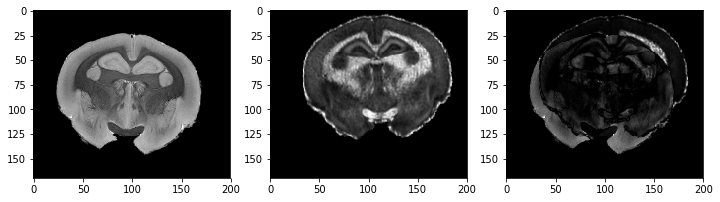

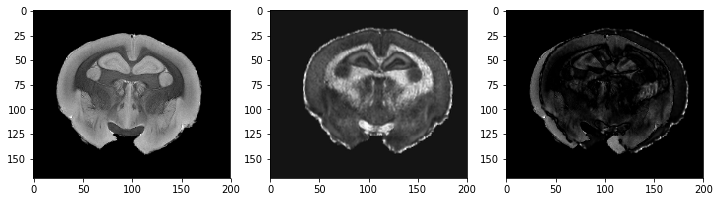

In [49]:
# TODO: get the optimal set of parameters and the cost function
ssd_par = ssd_result.x
ssd_fun = ssd_result.fun
print('The optimal set of parameters is: {} and the optimal cost function value is: {}'.format(ssd_par,ssd_fun))

# TODO: apply the new affine transformation (according to ssd_par) to fa
transf_matrix = np.array([ssd_par[0]*np.cos(ssd_par[2])+ssd_par[4]*ssd_par[0]*np.sin(ssd_par[2]),-ssd_par[1]*np.sin(ssd_par[2])+ssd_par[4]*ssd_par[1]*np.cos(ssd_par[2]), ssd_par[0]*ssd_par[3]*np.cos(ssd_par[2])+ssd_par[0]*np.sin(ssd_par[2]), -ssd_par[3]*ssd_par[1]*np.sin(ssd_par[2])+ssd_par[1]*np.cos(ssd_par[2])])
transf_matrix=np.reshape(transf_matrix,[2,2])
ssd_reg_fa = ndi.interpolation.affine_transform(fa,transf_matrix,offset=[ssd_par[5],ssd_par[6]])

# TODO: plot the images
# before the registration
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(t1,cmap='gray')
plt.subplot(132)
plt.imshow(fa,cmap='gray')
plt.subplot(133)
plt.imshow((t1-fa)**2,cmap='gray')
plt.show()
# after the registration
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(t1,cmap='gray')
plt.subplot(132)
plt.imshow(ssd_reg_fa,cmap='gray')
plt.subplot(133)
plt.imshow((t1-ssd_reg_fa)**2,cmap='gray')
plt.show()

Now you can repeat the registration procedure, but using the normalized mutual information function instead.

In [50]:
# TODO: initial guess for the parameters: the images are identical
initial_guess = np.array([1,1,0,0,0,0,0], np.float32)

# TODO: define the cost function
errtype = 'MI'

# TODO: optimization!
mi_result = optimize.minimize(error_affinetransf,initial_guess, options={'disp': True},args=(t1, fa, errtype))

Optimization terminated successfully.
         Current function value: 0.925462
         Iterations: 0
         Function evaluations: 9
         Gradient evaluations: 1


Check your results and answer to the same questions as those of the SSD registration above.<br> Then, __comment on the difference between the result obtained with SSD and the one obtained with MI.__

The optimal set of parameters is: [1. 1. 0. 0. 0. 0. 0.] and the optimal cost function value is: 0.9254623470892143


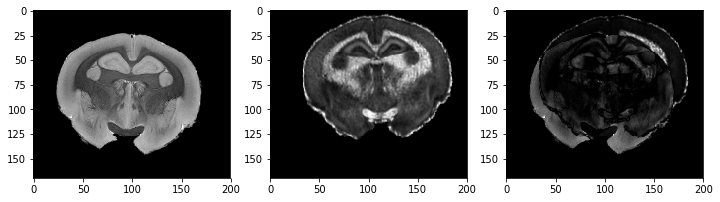

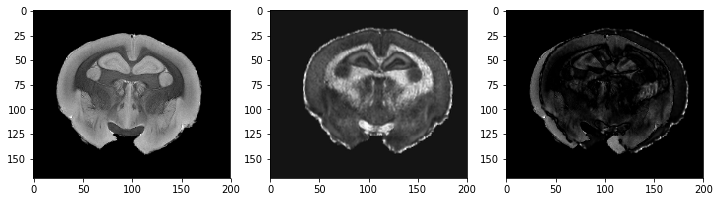

In [51]:
# TODO: get the optimal set of parameters and the cost function
mi_par = mi_result.x
mi_fun = mi_result.fun
print('The optimal set of parameters is: {} and the optimal cost function value is: {}'.format(mi_par,mi_fun))

# TODO: apply the new affine transformation (according to ssd_par) to fa
transf_matrix = np.array([mi_par[0]*np.cos(mi_par[2])+mi_par[4]*mi_par[0]*np.sin(mi_par[2]),-mi_par[1]*np.sin(mi_par[2])+mi_par[4]*mi_par[1]*np.cos(mi_par[2]), mi_par[0]*mi_par[3]*np.cos(mi_par[2])+mi_par[0]*np.sin(mi_par[2]), -mi_par[3]*mi_par[1]*np.sin(mi_par[2])+mi_par[1]*np.cos(mi_par[2])])
transf_matrix=np.reshape(transf_matrix,[2,2])

mi_reg_fa = ndi.interpolation.affine_transform(fa,transf_matrix,offset=[ssd_par[5],ssd_par[6]])


# TODO: plot the images
# before the registration
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(t1,cmap='gray')
plt.subplot(132)
plt.imshow(fa,cmap='gray')
plt.subplot(133)
plt.imshow((t1-fa)**2,cmap='gray')
plt.show()
# after the registration
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(t1,cmap='gray')
plt.subplot(132)
plt.imshow(ssd_reg_fa,cmap='gray')
plt.subplot(133)
plt.imshow((t1-ssd_reg_fa)**2,cmap='gray')
plt.show()